In [1]:
from pycigar.envs import Env
import yaml

import numpy as np
from scipy import signal
import math
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]

class FooEnv(Env):
    @property
    def observation_space(self):
        return Box(low=-float('inf'), high=float('inf'),
                   shape=(5,), dtype=np.float64)

    @property
    def action_space(self):
        return Box(low=0.5, high=1.5, shape=(5,), dtype=np.float64)

    def step(self, rl_actions=None, randomize_rl_update=None):
        """See parent class.
        """

        for _ in range(self.sim_params['env_config']["sims_per_step"]):
            self.env_time += 1
            
            # perform action update for PV inverter device
            if len(self.k.device.group_controllers.keys()) > 0:
                control_setting = []
                devices = []
                for group_controller_name, group_controller in self.k.device.group_controllers.items():
                    action = group_controller.get_action(self)
                    if isinstance(action, tuple):
                        devices.extend([group_controller.device_id])
                        control_setting.extend((action,)*len([group_controller.device_id]))
                    elif isinstance(action, dict):
                        devices.extend(action.keys())
                        control_setting.extend(action.values())
                self.k.device.apply_control(devices, control_setting)

            # perform action update for PV inverter device
            if len(self.k.device.get_local_device_ids()) > 0:
                control_setting = []
                for device_id in self.k.device.get_local_device_ids():
                    action = self.k.device.get_controller(device_id).get_action(self)
                    control_setting.append(action)
                self.k.device.apply_control(self.k.device.get_local_device_ids(), control_setting)


            self.additional_command()

            if self.k.time <= self.k.t:
                self.k.update(reset=False)

                # check whether the simulator sucessfully solved the powerflow
                converged = self.k.simulation.check_converged()
                if not converged:
                    break

            if self.k.time >= self.k.t:
                break

        # the episode will be finished if it is not converged.
        done = not converged or (self.k.time == self.k.t)
        obs = self.get_state()
        infos = {}
        reward = self.compute_reward(rl_actions)

        return obs, reward, done, infos

    def get_state(self):
        return [0, 0, 0, 0, 0]

    def compute_reward(self, rl_actions, **kwargs):
        return 0

stream = open("./data/pycigar_config.yaml", "r")
sim_params = yaml.safe_load(stream)

print('Simulation Complete')

Simulation Complete


In [2]:
from pycigar.utils.registry import register_devcon
from pycigar.controllers.battery_storage_controller import BatteryStorageController
from pycigar.devices.battery_storage_device import BatteryStorageDevice
from pycigar.devices.battery_storage_device_advanced import BatteryStorageDeviceAdvanced

# from pycigar.controllers.battery_peak_shaving_controller import BatteryPeakShavingController
from pycigar.controllers.battery_peak_shaving_controller_dist import BatteryPeakShavingControllerDist

# register_devcon('battery_storage_controller', BatteryStorageController)
# register_devcon('battery_peak_shaving_controller', BatteryPeakShavingController)
register_devcon('battery_peak_shaving_controller_dist', BatteryPeakShavingControllerDist)
register_devcon('battery_storage_device_advanced', BatteryStorageDeviceAdvanced)


'battery_storage_device_advanced'

In [3]:
sim_params

{'is_disable_log': False,
 'is_disable_y': False,
 'vectorized_mode': False,
 'env_config': {'clip_actions': 'True,', 'sims_per_step': 20},
 'simulation_config': {'network_model_directory': '/home/michael/Desktop/git/ceds-cigar/pycigar/zzz/data/ieee3.dss',
  'custom_configs': {'solution_mode': 1,
   'solution_number': 1,
   'solution_step_size': 1,
   'solution_control_mode': -1,
   'solution_max_control_iterations': 1000000,
   'solution_max_iterations': 30000,
   'power_factor': 0.9}},
 'scenario_config': {'network_data_directory': '/home/michael/Desktop/git/ceds-cigar/pycigar/zzz/data/load_solar_data.csv',
  'multi_config': False,
  'start_end_time': [3600, 5401],
  'custom_configs': {'load_scaling_factor': 1.25,
   'solar_scaling_factor': 0,
   'slack_bus_voltage': 1.04,
   'load_generation_noise': False,
   'power_factor': 0.9},
  'nodes': [{'name': 's701a',
    'devices': [{'name': 'pv_1',
      'device': 'pv_device',
      'custom_device_configs': {'default_control_setting': [0.

In [4]:
env = FooEnv(sim_params)
env.reset()
done = False
while not done:
    _, _, done, _ = env.step()
    # if env.k.time % 60 == 0:
    #     print('Time: ' + str(env.k.time))
    
print('Simulation Complete')

73.8270664183318
Measured apparent power [kVA]: 914.9162320759912
Measured active power lpf [kW]: 783.8663362075067
Measured reactive power lpf [kVAr]: 474.6500699205123
Measured apparent power lpf [kVA]: 916.3728072760164
Discharge
Active Power Control k-1 [kW]: 76.69946809655562
Load active power [kW]: 809.2184386867442
Load reactive power [kVAr]: 493.58042594805687
Load apparent power [kVA]: 947.869251737642
Discharge
Discharge power non rectified [kW]: 77.16536138067062
Discharge power [kW]: 77.16536138067062

Time: 1384
Device: bsd_2
Measured active power [kW]: 782.6618828367245
Measured reactive power [kVAr]: 473.8270664183318
Measured apparent power [kVA]: 914.9162320759912
Measured active power lpf [kW]: 783.8663362075067
Measured reactive power lpf [kVAr]: 474.6500699205123
Measured apparent power lpf [kVA]: 916.3728072760164
Discharge
Active Power Control k-1 [kW]: 76.69946809655562
Load active power [kW]: 809.2184386867442
Load reactive power [kVAr]: 493.58042594805687
Load 

KeyboardInterrupt: 

In [7]:
env.k.device.group_controllers['psc_1'].controller_id

AttributeError: 'BatteryPeakShavingControllerDist' object has no attribute 'name'

In [5]:
from pycigar.utils.logging import logger

Logger = logger()

Logger.log_dict.keys()

dict_keys(['bsd_1_psc', 'bsd_2_psc', 'pv_1', 'bsd_1', 'bsd_2', 's701a', 's702a', 's703a', 'network'])

In [6]:
env.k.device.devices

{'pv_1': {'device': <pycigar.devices.pv_inverter_device.PVDevice at 0x7f0546362350>,
  'controller': <pycigar.controllers.fixed_controller.FixedController at 0x7f0589c76210>,
  'node_id': 's701a'},
 'bsd_1': {'device': <pycigar.devices.battery_storage_device_advanced.BatteryStorageDeviceAdvanced at 0x7f0589408cd0>,
  'controller': <pycigar.controllers.battery_peak_shaving_controller_dist.BatteryPeakShavingControllerDist at 0x7f053aa48cd0>,
  'node_id': 's701a'},
 'bsd_2': {'device': <pycigar.devices.battery_storage_device_advanced.BatteryStorageDeviceAdvanced at 0x7f0589c72310>,
  'controller': <pycigar.controllers.battery_peak_shaving_controller_dist.BatteryPeakShavingControllerDist at 0x7f0589c52c50>,
  'node_id': 's701a'}}

In [7]:
# Logger.log_dict['s701a'].keys()
# Logger.log_dict['s701a']['q']
print(Logger.log_dict['bsd_1'].keys())
print(Logger.log_dict['bsd_1_psc'].keys())
# Logger.log_dict['bsd_1']['SOC']
# Logger.log_dict['pv_1'].keys()
# Logger.log_dict['pv_1']['q_out']

dict_keys(['control_setting', 'current_capacity', 'SOC', 'p_con', 'p_in', 'p_out', 'node'])
dict_keys(['control_setting', 'measured_active_power', 'measured_reactive_power', 'measured_apparent_power', 'measured_active_power_lpf', 'measured_reactive_power_lpf', 'measured_apparent_power_lpf', 'load_active_power', 'load_reactive_power', 'load_apparent_power', 'p_target', 'p_set', 'p_in', 'p_out'])


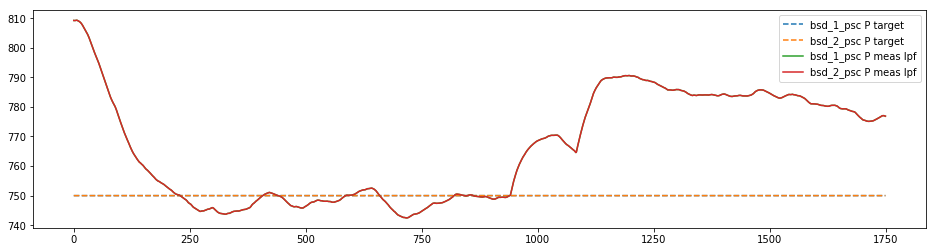

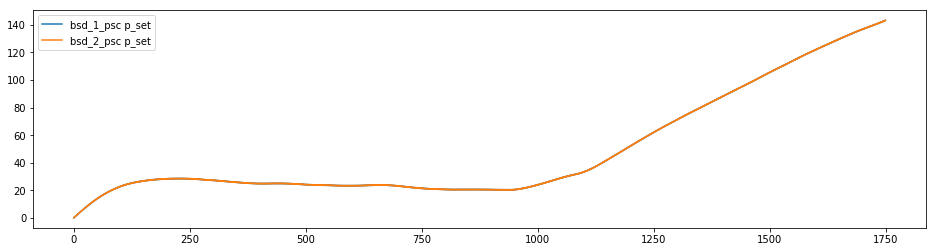

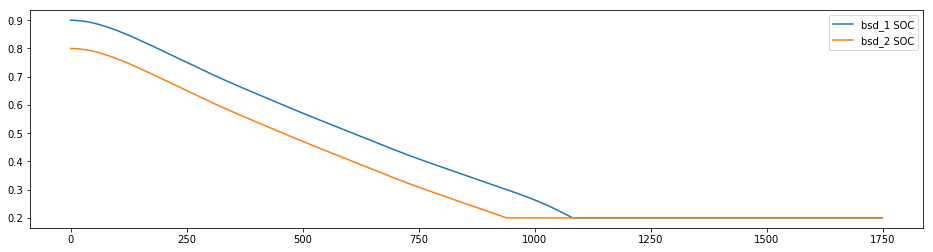

In [8]:
Logger.log_dict['bsd_1'].keys()
# Logger.log_dict['bsd_1']['SOC']

fig1 = plt.figure(figsize = [16, 4])
plt.plot(Logger.log_dict['bsd_1_psc']['p_target'],'--',label="bsd_1_psc P target")
plt.plot(Logger.log_dict['bsd_2_psc']['p_target'],'--',label="bsd_2_psc P target")
# plt.plot(Logger.log_dict['bsd_1_psc']['measured_active_power'],label="P meas")
plt.plot(Logger.log_dict['bsd_1_psc']['measured_active_power_lpf'],label="bsd_1_psc P meas lpf")
# plt.plot(Logger.log_dict['bsd_2_psc']['measured_active_power'],label="P meas")
plt.plot(Logger.log_dict['bsd_2_psc']['measured_active_power_lpf'],label="bsd_2_psc P meas lpf")
# plt.title('Battery State of Charge - External Control')
# plt.xlabel('Time [s]')
# plt.xlabel('SOC')
plt.legend()


fig1 = plt.figure(figsize = [16, 4])
plt.plot(Logger.log_dict['bsd_1_psc']['p_set'],label="bsd_1_psc p_set")
plt.plot(Logger.log_dict['bsd_2_psc']['p_set'],label="bsd_2_psc p_set")
# plt.plot(Logger.log_dict['bsd_1_psc']['measured_active_power_lpf'],label="P meas lpf")
# plt.title('Battery State of Charge - External Control')
# plt.xlabel('Time [s]')
# plt.xlabel('SOC')
plt.legend()


fig1 = plt.figure(figsize = [16, 4])
plt.plot(Logger.log_dict['bsd_1']['SOC'],label="bsd_1 SOC")
plt.plot(Logger.log_dict['bsd_2']['SOC'],label="bsd_2 SOC")
# plt.plot(Logger.log_dict['bsd_1_psc']['measured_active_power_lpf'],label="P meas lpf")
# plt.title('Battery State of Charge - External Control')
# plt.xlabel('Time [s]')
# plt.xlabel('SOC')
plt.legend()

plt.show()

# fig1.savefig('/home/michael/Desktop/temp/SOC.png')